In [21]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import joblib

# reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

for dirname, _, filenames in os.walk('datasets/northSulawesi/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

datasets/northSulawesi/bawangmerah_complete.csv
datasets/northSulawesi/bawangputih_complete.csv
datasets/northSulawesi/beras_complete.csv
datasets/northSulawesi/cabai_complete.csv
datasets/northSulawesi/dagingayam_complete.csv
datasets/northSulawesi/dagingsapi_complete.csv
datasets/northSulawesi/gulapasir_complete.csv
datasets/northSulawesi/minyak_complete.csv
datasets/northSulawesi/telurayam_complete.csv


In [22]:
FILE = 'datasets/northSulawesi/telurayam_complete.csv'  # เปลี่ยนชื่อไฟล์ที่นี่
df = pd.read_csv(FILE, parse_dates=['date'] if 'date' in pd.read_csv(FILE, nrows=0).columns else None)

# ถ้ามีคอลัมน์วันที่ ให้เรียงลำดับตามวันที่
if 'date' in df.columns:
    df = df.sort_values('date').reset_index(drop=True)

print("Shape:", df.shape)
display(df.head())
print("\nColumn & Type:")
print(df.dtypes)

Shape: (1864, 22)


,Tanggal,prices,day_count,month,season,weekday,is_holiday,rolling_mean_7,rolling_mean_30,lag_1,...,daily_delta,cpi,Inflasi_total,usd_idr,Temperature,Curah Hujan,Kelembapan,day_in_month,nilai_diff,percentage
0,2020-01-02,26600.0,1,1,Wet,3,False,NaN,NaN,NaN,...,NaN,115.818,0.0,13689.23145,27.22,15.89,83.85,2,NaN,0.00
1,2020-01-03,26600.0,2,1,Wet,4,False,NaN,NaN,26600.0,...,0.0,115.818,0.0,13884.78613,25.74,6.30,84.54,3,Rp0,0.00
2,2020-01-04,26600.0,3,1,Wet,5,False,NaN,NaN,26600.0,...,0.0,115.818,0.0,13884.78613,27.17,5.98,80.17,4,Rp0,0.00
3,2020-01-05,26600.0,4,1,Wet,6,False,NaN,NaN,26600.0,...,0.0,115.818,0.0,13884.78613,27.08,10.94,84.39,5,Rp0,0.00
4,2020-01-06,27200.0,5,1,Wet,0,False,NaN,NaN,26600.0,...,600.0,115.818,0.0,13934.31641,27.13,1.12,76.09,6,Rp600,2.26



Column & Type:
Tanggal             object
prices             float64
day_count            int64
month                int64
season              object
weekday              int64
is_holiday            bool
rolling_mean_7     float64
rolling_mean_30    float64
lag_1              float64
lag_7              float64
lag_30             float64
daily_delta        float64
cpi                float64
Inflasi_total      float64
usd_idr            float64
Temperature        float64
Curah Hujan        float64
Kelembapan         float64
day_in_month         int64
nilai_diff          object
percentage         float64
dtype: object


การวิเคราะห์ข้อมูลเชิง Exploratory Data Analysis (EDA)
- ดูสถิติสรุป
- นับข้อมูลที่หายไปต่อคอลัมน์

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Tanggal,1864,1864,2020-01-02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prices,1864.0,NaN,NaN,NaN,27733.234979,2996.59662,21700.0,25150.0,28400.0,29850.0,36850.0
day_count,1864.0,NaN,NaN,NaN,1083.535944,603.988017,1.0,569.75,1102.5,1613.25,2089.0
month,1864.0,NaN,NaN,NaN,6.352468,3.403089,1.0,3.0,6.0,9.0,12.0
season,1864,2,Dry,952,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday,1864.0,NaN,NaN,NaN,2.774142,1.933671,0.0,1.0,3.0,4.0,6.0
is_holiday,1864,2,False,1814,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rolling_mean_7,1268.0,NaN,NaN,NaN,28244.963948,2875.468542,21964.285714,26148.214286,28950.0,30358.928571,35200.0
rolling_mean_30,439.0,NaN,NaN,NaN,30009.153379,1463.149004,22290.0,29369.166667,29793.333333,30710.833333,35015.0
lag_1,1751.0,NaN,NaN,NaN,27804.483152,2982.418703,21700.0,25300.0,28500.0,29850.0,36850.0



Missing values per column:
Tanggal               0
prices                0
day_count             0
month                 0
season                0
weekday               0
is_holiday            0
rolling_mean_7      596
rolling_mean_30    1425
lag_1               113
lag_7               157
lag_30              231
daily_delta         113
cpi                   0
Inflasi_total         0
usd_idr               0
Temperature           0
Curah Hujan           0
Kelembapan            0
day_in_month          0
nilai_diff           86
percentage            0
dtype: int64


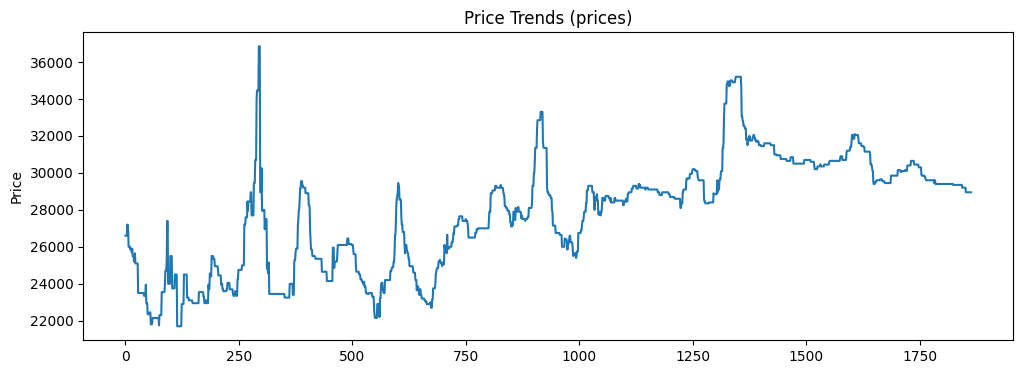

In [23]:
display(df.describe(include='all').T)
print("\nMissing values per column:")
print(df.isna().sum())

# Visual: price trend (if there is a 'prices' column)
# ภาพ: แนวโน้มราคา (ถ้ามีคอลัมน์ 'ราคา')
if 'prices' in df.columns:
    plt.figure(figsize=(12,4))
    plt.plot(df['prices'])
    plt.title("Price Trends (prices)")
    plt.ylabel("Price")
    plt.show()

วิศวกรรมคุณลักษณะ (ความล่าช้า, การหมุนเวียน) โดยไม่ลดค่า NaN
หลักการ:
- ค่าเฉลี่ยแบบหมุนเวียนคำนวณโดยใช้ min_periods=1 เพื่อหลีกเลี่ยงค่า NaN เริ่มต้น
- ความล่าช้าเกิดขึ้นจากการเลื่อน; เติมค่า NaN เริ่มต้นอย่างระมัดระวัง (เติมด้วยราคาปัจจุบัน)
- คุณลักษณะภายนอก (cpi, usd_idr, สภาพอากาศ) คำนวณโดยใช้ ffill->bfill
- เพิ่มคุณลักษณะที่ได้มาซึ่งมีประโยชน์ (การเปลี่ยนแปลงเปอร์เซ็นต์)

In [24]:
# make sure prices are there
# ตรวจสอบให้แน่ใจว่ามีราคา
if 'prices' not in df.columns:
    raise ValueError("Data does not contain a 'prices' column — adjust the column names.")

# Copy working df (so as not to modify the original)
d = df.copy()

# Fill in missing data for exogenous data with forward fill and then back fill (assuming the missing data is small and time series in nature)
exo_cols = [c for c in ['cpi', 'usd_idr', 'Temperature', 'Curah Hujan', 'Kelembapan'] if c in d.columns]
if exo_cols:
    d[exo_cols] = d[exo_cols].ffill().bfill()

# Rolling means — use min_periods=1 so that early rows have a value
d['rolling_mean_7'] = d['prices'].rolling(window=7, min_periods=1).mean()
d['rolling_mean_30'] = d['prices'].rolling(window=30, min_periods=1).mean()

# Lag features
d['lag_1'] = d['prices'].shift(1)
d['lag_7'] = d['prices'].shift(7)
d['lag_30'] = d['prices'].shift(30)

# NaN filling strategy for lag: fill initial NaNs with current price values (conservative)
# Rationale: on the first day there is no history, it is safer to assume the historical value = the price of that day
d['lag_1'] = d['lag_1'].fillna(d['prices'])
d['lag_7'] = d['lag_7'].fillna(d['prices'])
d['lag_30'] = d['lag_30'].fillna(d['prices'])

# Delta / pct change
d['pct_change_1'] = d['prices'].pct_change().fillna(0)
d['pct_change_7'] = d['prices'].pct_change(periods=7).fillna(0)

# day features
if 'date' in d.columns:
    d['weekday'] = d['date'].dt.dayofweek  # 0=Mon..6=Sun
    d['day_in_month'] = d['date'].dt.day
    d['month'] = d['date'].dt.month
else: 
    # if there is no date, try using the day_in_month column if available
    if 'day_in_month' not in d.columns:
        d['day_in_month'] = 0

# Check results
display(d.head(10))
print("\nMissing after imputation (should be 0 for features used):")
print(d[['rolling_mean_7','rolling_mean_30','lag_1','lag_7','lag_30','pct_change_1']].isna().sum())

,Tanggal,prices,day_count,month,season,weekday,is_holiday,rolling_mean_7,rolling_mean_30,lag_1,...,Inflasi_total,usd_idr,Temperature,Curah Hujan,Kelembapan,day_in_month,nilai_diff,percentage,pct_change_1,pct_change_7
0,2020-01-02,26600.0,1,1,Wet,3,False,26600.000000,26600.000000,26600.0,...,0.0,13689.23145,27.22,15.89,83.85,2,NaN,0.00,0.000000,0.000000
1,2020-01-03,26600.0,2,1,Wet,4,False,26600.000000,26600.000000,26600.0,...,0.0,13884.78613,25.74,6.30,84.54,3,Rp0,0.00,0.000000,0.000000
2,2020-01-04,26600.0,3,1,Wet,5,False,26600.000000,26600.000000,26600.0,...,0.0,13884.78613,27.17,5.98,80.17,4,Rp0,0.00,0.000000,0.000000
3,2020-01-05,26600.0,4,1,Wet,6,False,26600.000000,26600.000000,26600.0,...,0.0,13884.78613,27.08,10.94,84.39,5,Rp0,0.00,0.000000,0.000000
4,2020-01-06,27200.0,5,1,Wet,0,False,26720.000000,26720.000000,26600.0,...,0.0,13934.31641,27.13,1.12,76.09,6,Rp600,2.26,0.022556,0.000000
5,2020-01-07,27200.0,6,1,Wet,1,False,26800.000000,26800.000000,27200.0,...,0.0,13926.50000,26.67,22.50,81.65,7,Rp0,0.00,0.000000,0.000000
6,2020-01-08,26900.0,7,1,Wet,2,False,26814.285714,26814.285714,27200.0,...,0.0,13867.23633,26.12,12.10,87.27,8,-Rp300,-1.10,-0.011029,0.000000
7,2020-01-09,26000.0,8,1,Wet,3,False,26728.571429,26712.500000,26900.0,...,0.0,13886.93945,26.64,7.82,84.93,9,-Rp900,-3.35,-0.033457,-0.022556
8,2020-01-10,26000.0,9,1,Wet,4,False,26642.857143,26633.333333,26000.0,...,0.0,13827.56055,26.76,14.01,87.64,10,Rp0,0.00,0.000000,-0.022556
9,2020-01-11,26000.0,10,1,Wet,5,False,26557.142857,26570.000000,26000.0,...,0.0,13827.56055,27.01,7.98,84.03,11,Rp0,0.00,0.000000,-0.022556



Missing after imputation (should be 0 for features used):
rolling_mean_7     0
rolling_mean_30    0
lag_1              0
lag_7              0
lag_30             0
pct_change_1       0
dtype: int64


การเลือกคุณลักษณะขั้นสุดท้าย
- เลือกคอลัมน์ที่จะรวมอยู่ในแบบจำลอง (หลีกเลี่ยงคอลัมน์ที่ไม่ใช่ตัวเลข)
- แสดงความสัมพันธ์โดยย่ออีกครั้ง

,prices,rolling_mean_7,rolling_mean_30,lag_1,lag_7,lag_30,pct_change_1,pct_change_7,weekday,day_in_month,cpi,usd_idr,Temperature,Curah Hujan,Kelembapan
0,26600.0,26600.0,26600.0,26600.0,26600.0,26600.0,0.000000,0.0,3,2,115.818,13689.23145,27.22,15.89,83.85
1,26600.0,26600.0,26600.0,26600.0,26600.0,26600.0,0.000000,0.0,4,3,115.818,13884.78613,25.74,6.30,84.54
2,26600.0,26600.0,26600.0,26600.0,26600.0,26600.0,0.000000,0.0,5,4,115.818,13884.78613,27.17,5.98,80.17
3,26600.0,26600.0,26600.0,26600.0,26600.0,26600.0,0.000000,0.0,6,5,115.818,13884.78613,27.08,10.94,84.39
4,27200.0,26720.0,26720.0,26600.0,27200.0,27200.0,0.022556,0.0,0,6,115.818,13934.31641,27.13,1.12,76.09


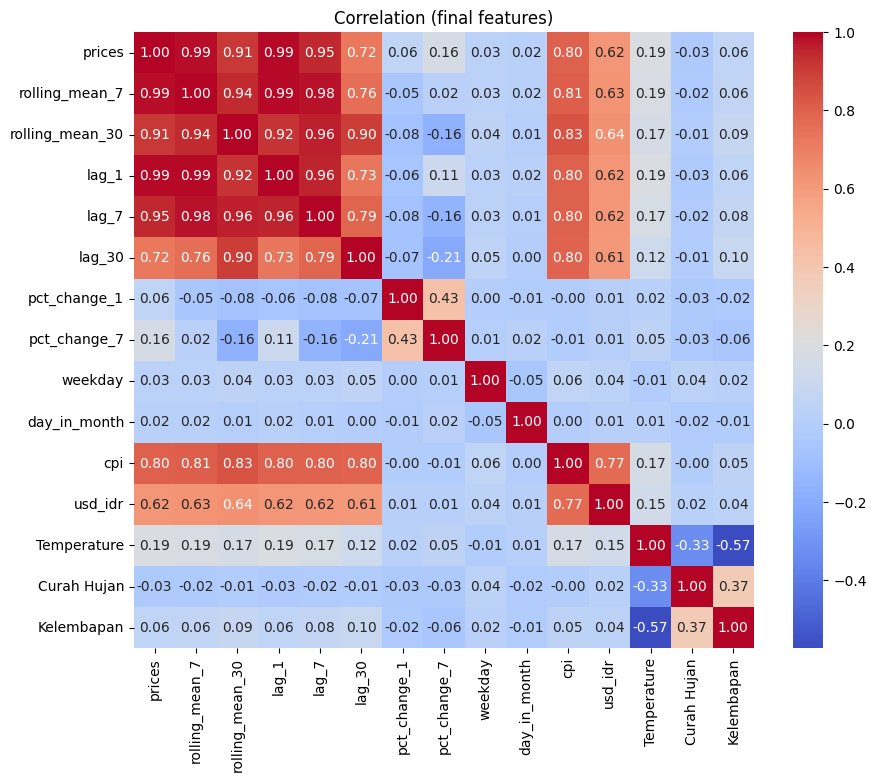

In [25]:
features = [
    'prices', 'rolling_mean_7', 'rolling_mean_30', 'lag_1', 'lag_7', 'lag_30',
    'pct_change_1', 'pct_change_7', 'weekday', 'day_in_month'
]
# เพิ่มปัจจัยภายนอกถ้ามี
for ex in exo_cols:
    features.append(ex)

# ให้แน่ใจว่ามีทุกอย่างอยู่
missing = [c for c in features if c not in d.columns]
if missing:
    raise ValueError("Missing column: " + ", ".join(missing))

df_feat = d[features].copy()
display(df_feat.head())

# ความสัมพันธ์ของคุณลักษณะ (ตัวเลขเท่านั้น)
plt.figure(figsize=(10,8))
sns.heatmap(df_feat.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation (final features)")
plt.show()

การปรับขนาดและการสร้างลำดับ (ป้องกันการรั่วไหลของข้อมูล) (data leakage)
- ใช้ window_size = 30
- ปรับตัวปรับขนาดให้พอดีกับแถวที่จะปรากฏในลำดับการฝึกเท่านั้น
- แปลงข้อมูลทั้งหมด แล้วสร้างลำดับ X, y

In [26]:
raw_values = df_feat.values  # shape (n_rows, n_features)
n_rows, n_features = raw_values.shape
window_size = 30

# Count sequences available
seq_count = n_rows - window_size
if seq_count <= 0:
    raise ValueError("ข้อมูลไม่เพียงพอสำหรับขนาด Window ที่เลือก")

# Training sequences count (time-based split)
train_seq_count = int(seq_count * 0.8)
rows_for_scaler = train_seq_count + window_size  # rows needed to construct training windows
print(f"n_rows={n_rows}, seq_count={seq_count}, train_seq_count={train_seq_count}, rows_for_scaler={rows_for_scaler}")

scaler = MinMaxScaler()
scaler.fit(raw_values[:rows_for_scaler, :])  # fit only on training rows (prevent leakage)

scaled_all = scaler.transform(raw_values)     # transform all rows for convenience

# Create sequences
def create_sequences_from_scaled(scaled_array, window):
    X, y = [], []
    for i in range(len(scaled_array) - window):
        X.append(scaled_array[i:i+window])
        y.append(scaled_array[i+window, 0])  # target: kolom 'prices' (index 0)
    return np.array(X), np.array(y)

X, y = create_sequences_from_scaled(scaled_all, window_size)
print("Total sequences:", X.shape, y.shape)

# Split
X_train, X_test = X[:train_seq_count], X[train_seq_count:]
y_train, y_test = y[:train_seq_count], y[train_seq_count:]
print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)

n_rows=1864, seq_count=1834, train_seq_count=1467, rows_for_scaler=1497
Total sequences: (1834, 30, 15) (1834,)
Shapes -> X_train: (1467, 30, 15) X_test: (367, 30, 15)


Model architecture: LSTM_v2_Imputed
Architecture:
- LSTM(128, return_sequences=True)
- Dropout(0.3)
- LSTM(64)
- Dropout(0.3)
- Dense(64, relu)
- Dense(1)

Rationale:
- Two LSTM layers help the model capture complex temporal patterns
- Dropout for regularization
- Dense layers help with non-linear mapping before output

In [27]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

C:\Users\anuru\miniconda3\envs\Tensorflow\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 128)             │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 127,361 (497.50 KB)

 Trainable params: 127,361 (497.50 KB)

 Non-trainable params: 0 (0.00 B)

Training
- EarlyStopping: stop if val_loss doesn't improve
- ReduceLROnPlateau: reduce LR if it plateaus
- ModelCheckpoint: save the best model
- Goal: optimize the model while avoiding overfitting

In [28]:
import time

start_time = time.time()

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
ckpt_path = "models/LSTM_v2_Imputed_best.keras" #แก้ชื่อไฟล์ตรงนี้
mc = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1)

print("\n" + "="*60)
print("🚀 เริ่มการเทรนโมเดล LSTM")
print("="*60)
print()

epoch = 10 #ใส่จำนวนรอบตรงนี้

# เทรนโมเดล
history = model.fit(
    X_train, y_train,
    epochs=epoch,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es, rlr, mc],
    verbose=1
)

# สรุปผล
elapsed = time.time() - start_time
total_epochs = len(history.history['loss'])
minutes, seconds = divmod(int(elapsed), 60)

print("\n" + "="*60)
if total_epochs < epoch:
    print(f"⏸️ การเทรนหยุดด้วย Early Stopping")
    print(f"✅ หยุดที่ Epoch: {total_epochs}/{epoch}")
else:
    print(f"✅ การเทรนเสร็จสมบูรณ์ (ครบ {total_epochs} epochs)")

print(f"⏱️ เวลาที่ใช้: {minutes} นาที {seconds} วินาที")
print(f"💾 โมเดลบันทึกที่: {ckpt_path}")
print("="*60)
print()


🚀 เริ่มการเทรนโมเดล LSTM

Epoch 1/10
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0434
Epoch 1: val_loss improved from None to 0.00597, saving model to models/LSTM_v2_Imputed_best.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0213 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0080
Epoch 2: val_loss improved from 0.00597 to 0.00335, saving model to models/LSTM_v2_Imputed_best.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0074 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0068
Epoch 3: val_loss did not improve from 0.00335
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0063 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0046
Epoch 4: val_loss improved from 0.00335 to 0.00323, saving model to models/LSTM_v2_Imputed_best.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0045 - val_los

In [29]:
"""
Load best model & evaluation
- Muat model terbaik dari checkpoint
- Prediksi X_test (scaled)
- Inverse transform predictions & actual ke skala asli
- Hitung MSE, MAE, RMSE
"""
if os.path.exists(ckpt_path):
    model = load_model(ckpt_path)

# Predict (scaled)
pred_scaled = model.predict(X_test)

# inverse transform helper
def inv_transform_target(scaled_target_array, scaler, n_features):
    """
    Inverse transform helper to return prices to their original scale.
    scaled_target_array: an (N,) or (N,1) array containing the scaled targets (column 0)
    scaler: the fitted scaler
    n_features: the total number of features
    """
    scaled_target_array = scaled_target_array.flatten()
    dummy = np.zeros((len(scaled_target_array), n_features))
    dummy[:, 0] = scaled_target_array
    return scaler.inverse_transform(dummy)[:, 0]

y_test_inv = inv_transform_target(y_test, scaler, n_features)
pred_inv = inv_transform_target(pred_scaled, scaler, n_features)

mse = mean_squared_error(y_test_inv, pred_inv)
mae = mean_absolute_error(y_test_inv, pred_inv)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step
MSE: 247103.88, MAE: 417.04, RMSE: 497.10


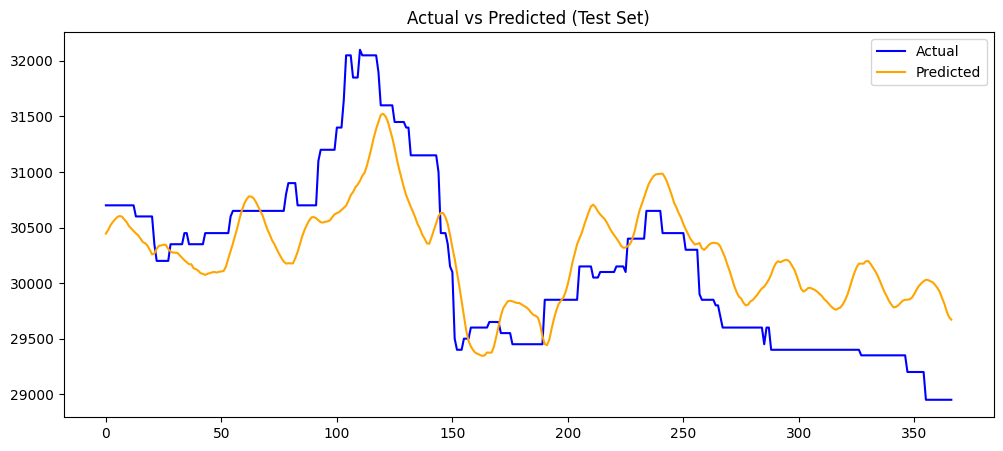

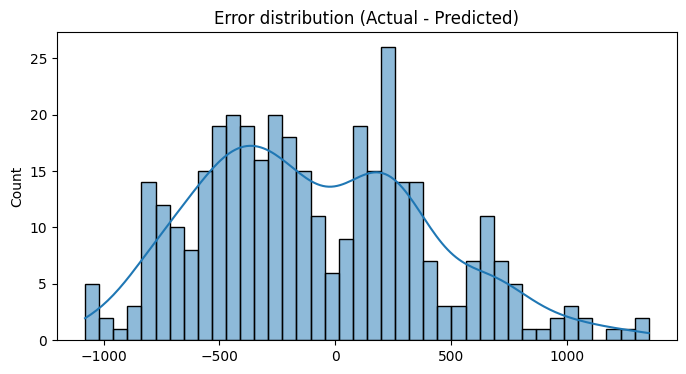

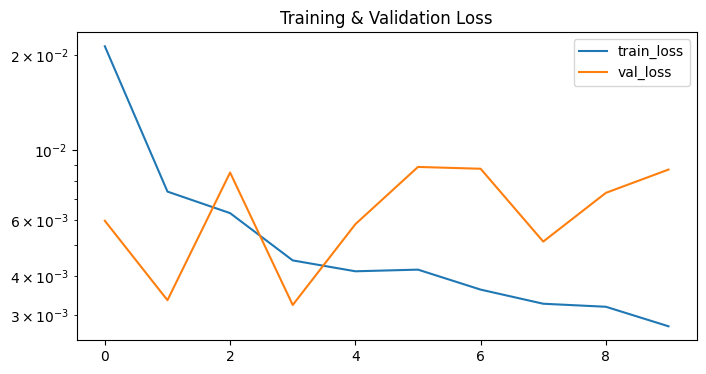

In [30]:
"""
Visualisasi:
- Actual vs Predicted
- Error distribution
- Training/validation loss
"""
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual', color='blue')
plt.plot(pred_inv, label='Predicted', color='orange')
plt.title("Actual vs Predicted (Test Set)")
plt.legend()
plt.show()

# Error distribution
errors = y_test_inv - pred_inv
plt.figure(figsize=(8,4))
sns.histplot(errors, bins=40, kde=True)
plt.title("Error distribution (Actual - Predicted)")
plt.show()

# Loss curves
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [31]:
"""
Save model & scaler
- Save LSTM_v2_Imputed model and scaler
- Log simple metadata (version, date)
"""
MODEL_OUT = "models/exports/LSTM_v2_Imputed.keras"  
SCALER_OUT = "models/exports/price_scaler_v2.pkl"

# บันทึกโมเดล
model.save(MODEL_OUT)
print(f"✅ บันทึกโมเดลที่ {MODEL_OUT}")

# บันทึก scaler
joblib.dump(scaler, SCALER_OUT)
print(f"✅ บันทึก scaler ที่ {SCALER_OUT}")

# บันทึก metadata
import json
meta = {
    "model_name": "LSTM_v2_Imputed",
    "window_size": window_size,
    "features": features,
    "n_features": n_features,
    "metrics": {
        "mse": float(mse),
        "mae": float(mae),
        "rmse": float(rmse)
    }
}

with open("models/exports/LSTM_v2_Imputed_metadata.json", "w") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("✅ บันทึก metadata")
print("\n" + "="*60)
print("✅ บันทึกทุกไฟล์เรียบร้อยแล้ว!")
print("="*60)

✅ บันทึกโมเดลที่ models/exports/LSTM_v2_Imputed.keras
✅ บันทึก scaler ที่ models/exports/price_scaler_v2.pkl
✅ บันทึก metadata

✅ บันทึกทุกไฟล์เรียบร้อยแล้ว!


ฟังก์ชัน predict_next_day
- อินพุต: model, scaler, raw_values ​​​​(คุณสมบัติดั้งเดิมในสเกลเดิม), window_size
- เอาต์พุต: ราคาที่คาดการณ์ไว้ (สเกลเดิม)
- หมายเหตุ: ตรวจสอบให้แน่ใจว่า raw_values ​​​​สุดท้ายมีคุณสมบัติที่เรากำหนดไว้

In [42]:
def predict_next_day(model, scaler, raw_values_array, window_size=30):
    # raw_values_array: ndarray (n_rows, n_features) in original scale (same order as 'features')
    last_window_raw = raw_values_array[-window_size:, :]
    last_window_scaled = scaler.transform(last_window_raw)
    X_input = last_window_scaled.reshape(1, window_size, last_window_scaled.shape[1])
    pred_scaled = model.predict(X_input)
    # inverse transform prediction
    dummy = np.zeros((1, n_features))
    dummy[0,0] = pred_scaled.flatten()[0]
    pred_inv = scaler.inverse_transform(dummy)[0,0]
    return float(pred_inv)

# contoh penggunaan (raw_values adalah df_feat.values dari Cell 5)
pred_next = predict_next_day(model, scaler, df_feat.values, window_size=window_size)
print("Prediksi harga besok (1-step):", pred_next)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Prediksi harga besok (1-step): 29294.16639506817


In [43]:
# contoh: input manual
harga_hari_ini = float(input("Masukkan harga hari ini (simulasi): "))

# gunakan row terakhir sebagai basis fitur
last_row_raw = raw_values[-1].copy()  # raw_values diambil dari Cell 6 awal (df_feat.values)
new_row = last_row_raw.copy()
new_row[0] = harga_hari_ini

# update rolling & lag di new_row: (opsional, sederhana)
# lebih baik compute new_row fitur sebenarnya via helper fungsi yang memakai history + sumber exogenous
raw_values_upd = np.vstack([raw_values, new_row])

pred_after_input = predict_next_day(model, scaler, raw_values_upd, window_size)
print("Prediksi harga besok setelah input harga terbaru:", pred_after_input)

Masukkan harga hari ini (simulasi):  30


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediksi harga besok setelah input harga terbaru: 28287.903563678265


https://www.kaggle.com/code/rickymambu/price-prediction-using-lstm